# Extreme Gradient boosting on Amazon fine food dataset

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
To perform Extreme gradient boosting on different vectors like BOW, Tf-idf, Avg-W2vec & Tf-idf_W2vec.

In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [10]:
#Importing Train and test dataset
train_data=pd.read_csv("E:/Applied AI assignments/Amazon_fine_train_data.csv")
test_data=pd.read_csv("E:/Applied AI assignments/Amazon_fine_test_data.csv")

In [11]:
train_data=train_data.astype(str)
test_data=test_data.astype(str)

In [12]:
train_data.shape

(80000, 13)

In [6]:
train_data['Score'].value_counts()

positive    70407
negative     9593
Name: Score, dtype: int64

In [ ]:
test_data.shape

In [8]:
test_data['Score'].value_counts()

positive    17322
negative     2678
Name: Score, dtype: int64

In [13]:
#Train data
y_train = train_data['Score']
x_train = train_data['CleanedText']

#Test data
y_test = test_data['Score']
x_test = test_data['CleanedText'] 

In [14]:
#Replacing Positive score with 0 and negative score with 1
y_train.replace('negative',1,inplace=True)
y_train.replace('positive',0,inplace=True)

y_test.replace('negative',1,inplace=True)
y_test.replace('positive',0,inplace=True)

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Randomisedsearch CV

In [16]:
n_estimators=list(range(100,1100,100))
max_depth=list(range(1,50))
learning_rate=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

T= TimeSeriesSplit(n_splits=5)

param_distributions  = dict(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)
print(param_distributions)

# instantiate and fit the grid
grid = RandomizedSearchCV(XGBClassifier(), param_distributions, cv=T, scoring='f1', return_train_score=False,n_jobs=-1)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


Binary Bow

In [78]:
count_vect = CountVectorizer(binary=True)

#Train data
vocabulary = count_vect.fit(x_train) #in scikit-learn
Bow_x_train= count_vect.transform(x_train)
print("the type of count vectorizer ",type(Bow_x_train))
print("the shape of out text BOW vectorizer ",Bow_x_train.get_shape())
print("the number of unique words ", Bow_x_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (80000, 33433)
the number of unique words  33433


In [79]:
#Test data
Bow_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(Bow_x_test))
print("the shape of out text BOW vectorizer ",Bow_x_test.get_shape())
print("the number of unique words ", Bow_x_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 33433)
the number of unique words  33433


In [27]:
grid.fit(Bow_x_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.601488197668569
{'n_estimators': 900, 'max_depth': 15, 'learning_rate': 0.5}


Text(0,0.5,'Cross-Validated Error')

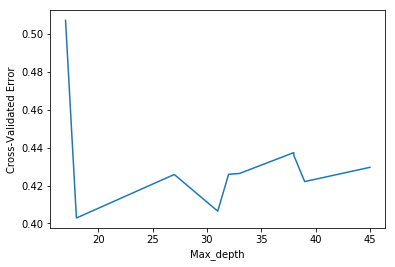

In [39]:
#Plotting Max_depth v/s CV_error
a=pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
a['max_depth'] = [d.get('max_depth') for d in a['params']]
b=a.sort_values(['max_depth'])
CV_Error=1-b['mean_test_score']
max_depth =b['max_depth']


plt.plot(max_depth,CV_Error)
plt.xlabel('Max_depth')
plt.ylabel('Cross-Validated Error')

In [80]:
from sklearn.metrics import f1_score
#{'n_estimators': 900, 'max_depth': 15, 'learning_rate': 0.5}
xgb_optimal=XGBClassifier(n_estimators=900,max_depth=15,learning_rate=0.5,gamma=25,n_jobs=-1)

# fitting the model
xgb_optimal.fit(Bow_x_train, y_train)

# predict the response
pred_bow = xgb_optimal.predict(Bow_x_test)

# evaluate f1_score
f1_score = f1_score(y_test, pred_bow)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,xgb_optimal.predict(Bow_x_train)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_bow))

The overall f1_score for the Train Data is :  0.5730344780313935
The overall f1_score for the Test Data is :  0.5529241179313679


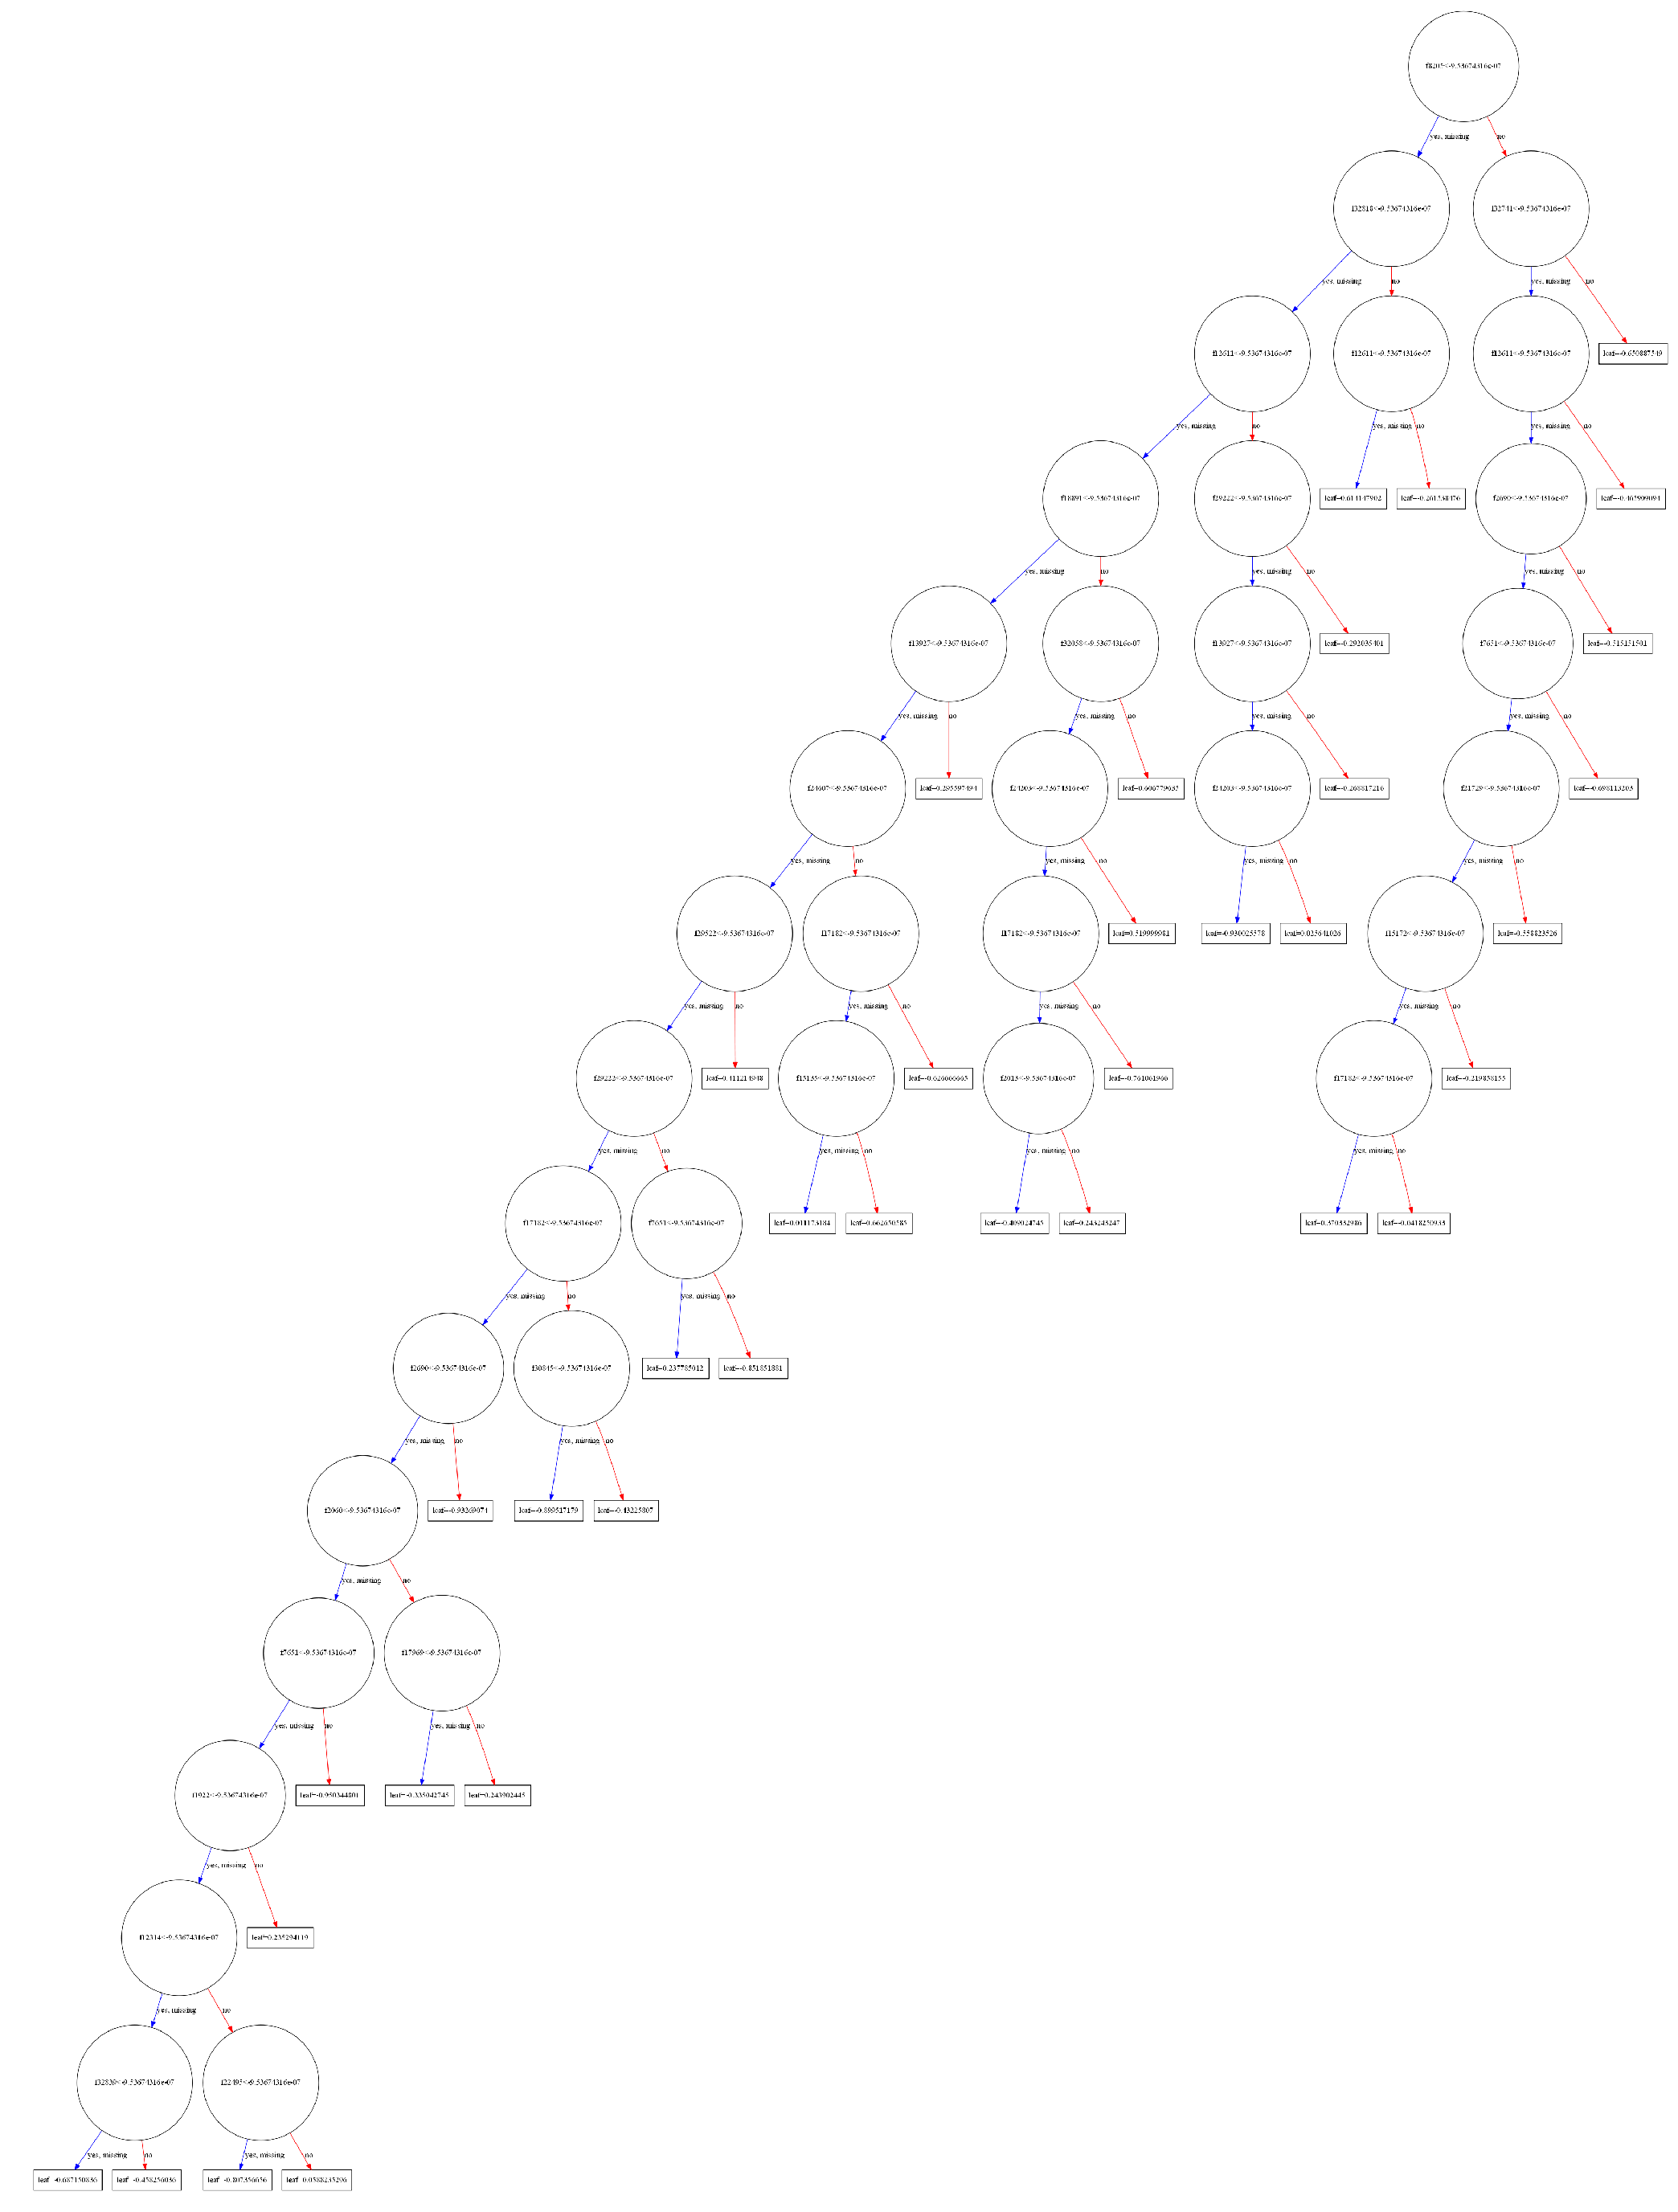

In [81]:
from xgboost import plot_tree
import xgboost as xgb
xgb.plot_tree(xgb_optimal,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

************ Top 20 Features *******************


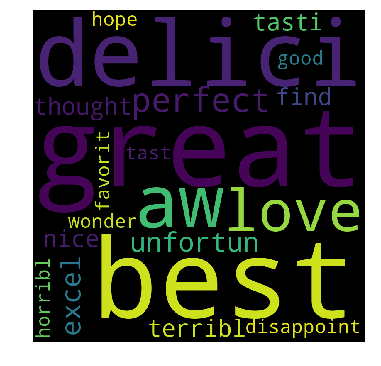

In [82]:
#Feature importance
feature_names = np.array(vocabulary.get_feature_names())
indices = np.argsort(xgb_optimal.feature_importances_)[::-1]

#Top 20 features
f=feature_names[indices[:20]]

sf = ""
for i in f:
    sf += str(i)+","

print("************ Top 20 Features *******************")
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(sf) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


In [83]:
#Confusion matrix
C = confusion_matrix(y_test, pred_bow)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
labels = [0,1]

-------------------- Confusion matrix --------------------


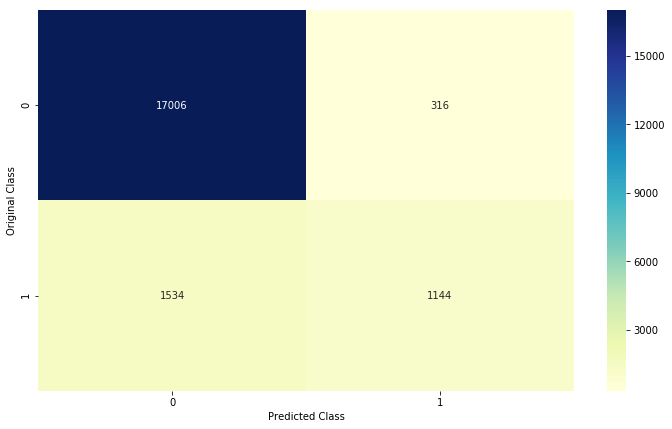

-------------------- Precision matrix (Columm Sum=1) --------------------


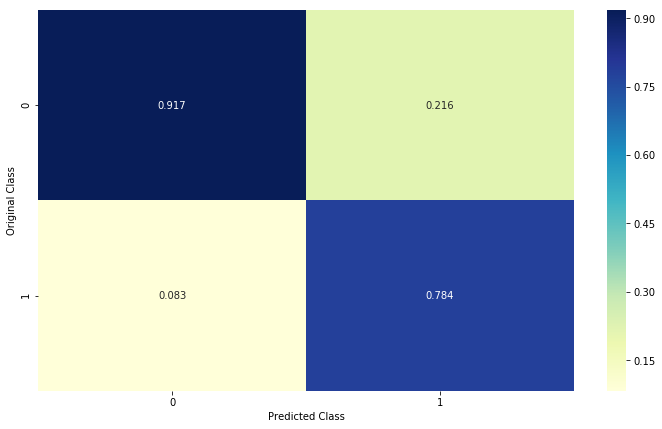

-------------------- Recall matrix (Row sum=1) --------------------


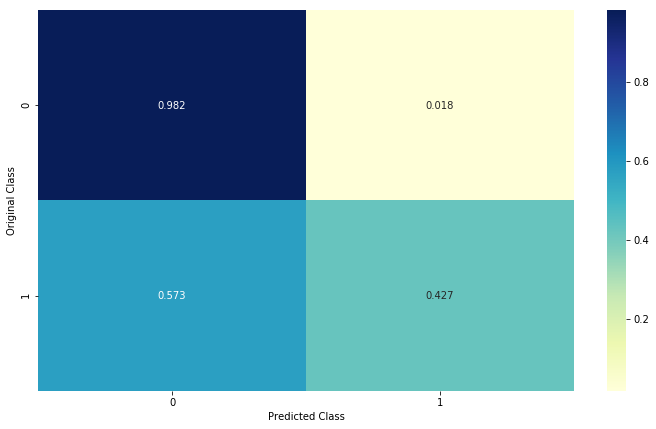

In [84]:
 print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
    
    # representing B in heatmap format
print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### Tf-idf

In [68]:
#Initiating Vectorizer
count_vect = TfidfVectorizer(ngram_range=(1,2))

#Train data
vocabulary = count_vect.fit(x_train)
Tfidf_x_train= count_vect.transform(x_train)
print("the type of count vectorizer ",type(Tfidf_x_train))
print("the shape of out text BOW vectorizer ",Tfidf_x_train.get_shape())
print("the number of unique words ", Tfidf_x_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (80000, 1013943)
the number of unique words  1013943


In [69]:
#Test data
Tfidf_x_test= count_vect.transform(x_test)
print("the type of count vectorizer ",type(Tfidf_x_test))
print("the shape of out text BOW vectorizer ",Tfidf_x_test.get_shape())
print("the number of unique words ", Tfidf_x_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 1013943)
the number of unique words  1013943


In [31]:
grid_tfidf=grid.fit(Tfidf_x_train, y_train)

# examine the best model
print(grid_tfidf.best_score_)
print(grid_tfidf.best_params_)

0.5971658522910812
{'n_estimators': 600, 'max_depth': 18, 'learning_rate': 0.7}


Text(0,0.5,'Cross-Validated Error')

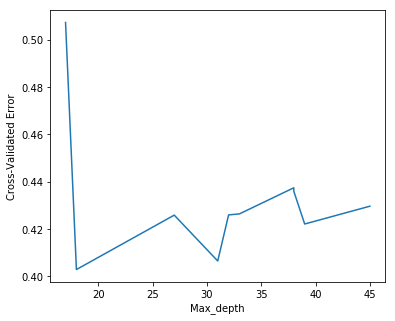

In [71]:
#Plotting Max_depth v/s CV_error
a=pd.DataFrame(grid_tfidf.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
a['max_depth'] = [d.get('max_depth') for d in a['params']]
b=a.sort_values(['max_depth'])
CV_Error=1-b['mean_test_score']
max_depth =b['max_depth']

plt.figure(figsize=(6,5))
plt.plot(max_depth,CV_Error)
plt.xlabel('Max_depth')
plt.ylabel('Cross-Validated Error')


In [70]:

#{'n_estimators': 600, 'max_depth': 18, 'learning_rate': 0.7}
xgb_optimal=XGBClassifier(n_estimators=600,max_depth=18,learning_rate=0.7,gamma=30,n_jobs=-1)

# fitting the model
xgb_optimal.fit(Tfidf_x_train, y_train)

# predict the response
pred_tfidf = xgb_optimal.predict(Tfidf_x_test)

# evaluate accuracy
f1_score = f1_score(y_test, pred_tfidf)

In [71]:
# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,xgb_optimal.predict(Tfidf_x_train)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_tfidf))

The overall f1_score for the Train Data is :  0.5975351179432813
The overall f1_score for the Test Data is :  0.5673825820155771


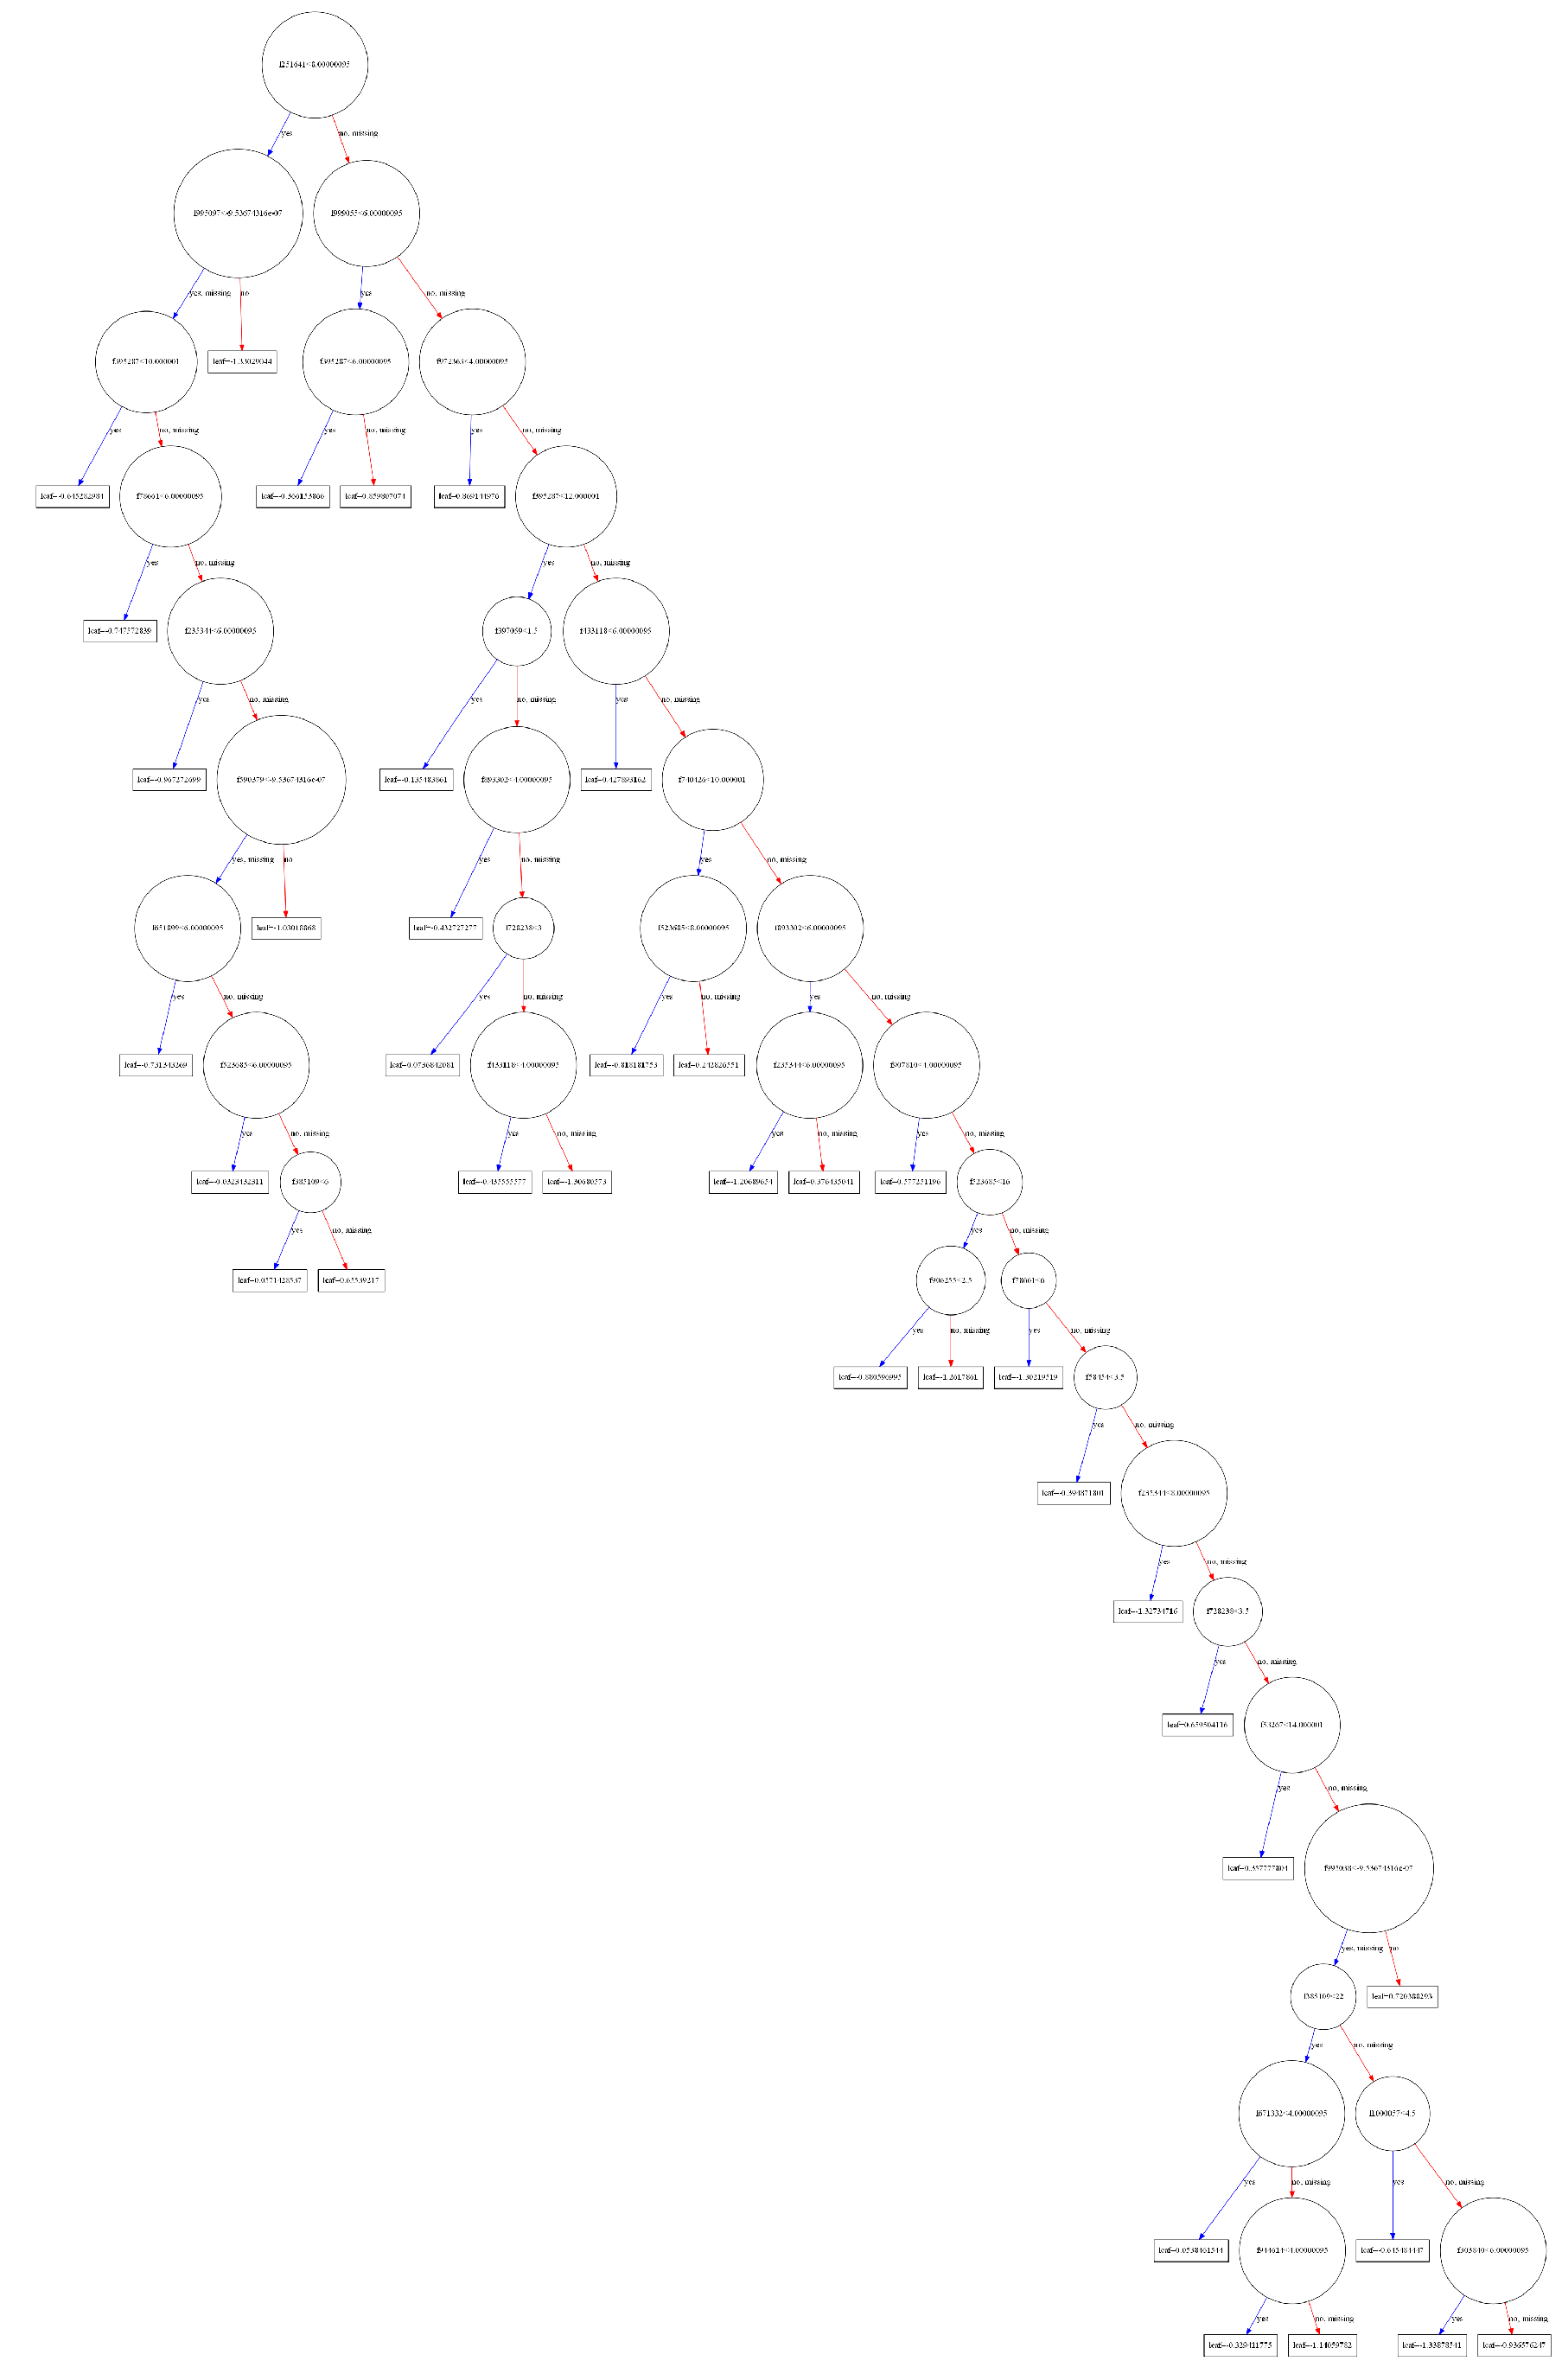

In [74]:
from xgboost import plot_tree
import xgboost as xgb

xgb.plot_tree(xgb_optimal,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

************ Top 20 Features *******************


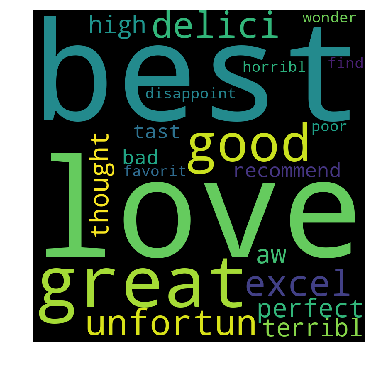

In [75]:
#Feature importance
feature_names = np.array(vocabulary.get_feature_names())
indices = np.argsort(xgb_optimal.feature_importances_)[::-1]

#Top 20 features
f=feature_names[indices[:20]]

sf = ""
for i in f:
    sf += str(i)+","

print("************ Top 20 Features *******************")
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10).generate(sf) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


In [76]:
#Confusion matrix
C = confusion_matrix(y_test, pred_tfidf)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
labels = [0,1]

-------------------- Confusion matrix --------------------


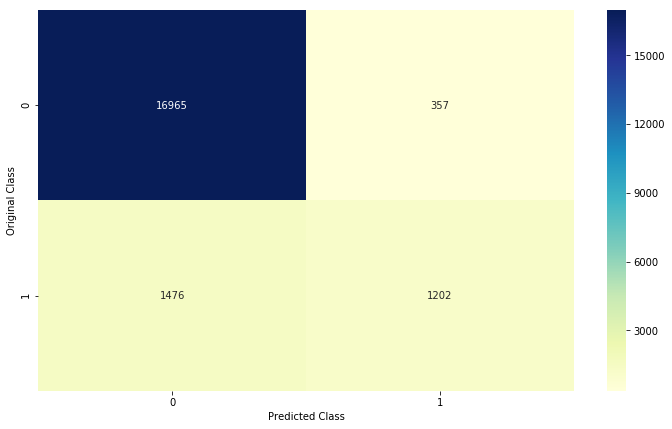

-------------------- Precision matrix (Columm Sum=1) --------------------


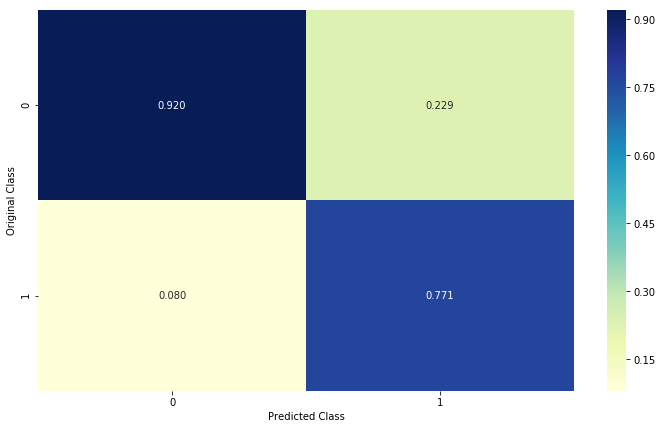

-------------------- Recall matrix (Row sum=1) --------------------


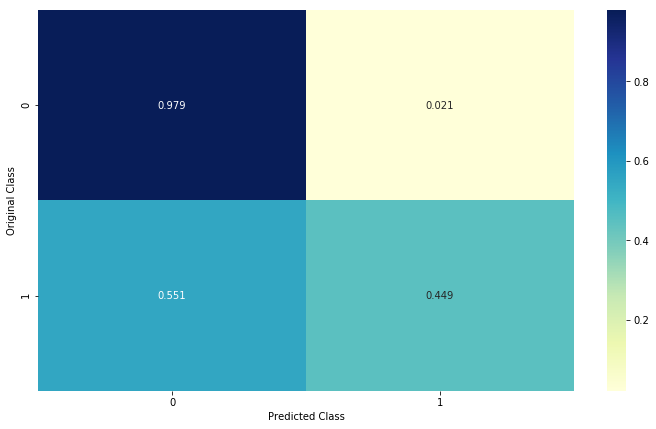

In [77]:
 print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
    
    # representing B in heatmap format
print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### Avg-W2Vec

In [54]:
#W2V list of Training data
i=0
list_of_sent_train=[]
for sent in train_data['CleanedText'].values:
    list_of_sent_train.append(sent.split())

In [55]:
#W2V List of Test data
i=0
list_of_sent_test=[]
for sent in test_data['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [56]:
#Training W2V train model
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=200, workers=6)

In [57]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  11361
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


In [58]:
#Train data
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train_avgw2v.append(sent_vec)
print(len(sent_vectors_train_avgw2v))
print(len(sent_vectors_train_avgw2v[0]))

80000
200


In [59]:
#Test data
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test_avgw2v.append(sent_vec)
print(len(sent_vectors_test_avgw2v))
print(len(sent_vectors_test_avgw2v[0]))

20000
200


In [60]:
sent_vectors_train_avgw2v=np.asarray(sent_vectors_train_avgw2v)
sent_vectors_test_avgw2v=np.asarray(sent_vectors_test_avgw2v)

In [61]:
grid.fit(sent_vectors_train_avgw2v, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.5492236670295039
{'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.6}


Text(0,0.5,'Cross-Validated Error')

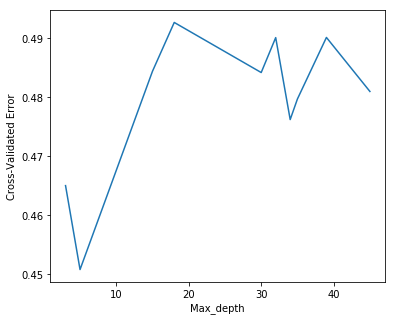

In [62]:
#Plotting Max_depth v/s CV_error
a=pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
a['max_depth'] = [d.get('max_depth') for d in a['params']]
b=a.sort_values(['max_depth'])
CV_Error=1-b['mean_test_score']
max_depth =b['max_depth']

plt.figure(figsize=(6,5))
plt.plot(max_depth,CV_Error)
plt.xlabel('Max_depth')
plt.ylabel('Cross-Validated Error')

In [63]:

#{'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.6}
xgb_optimal=XGBClassifier(n_estimators=600,max_depth=5,learning_rate=0.6,gamma=20,n_jobs=-1)

# fitting the model
xgb_optimal.fit(sent_vectors_train_avgw2v, y_train)

# predict the response
pred_avg_w2v = xgb_optimal.predict(sent_vectors_test_avgw2v)

# evaluate f1_score
f1_score = f1_score(y_test, pred_avg_w2v)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,xgb_optimal.predict(sent_vectors_train_avgw2v)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_avg_w2v))

The overall f1_score for the Train Data is :  0.6463444553483808
The overall f1_score for the Test Data is :  0.5497440462942356


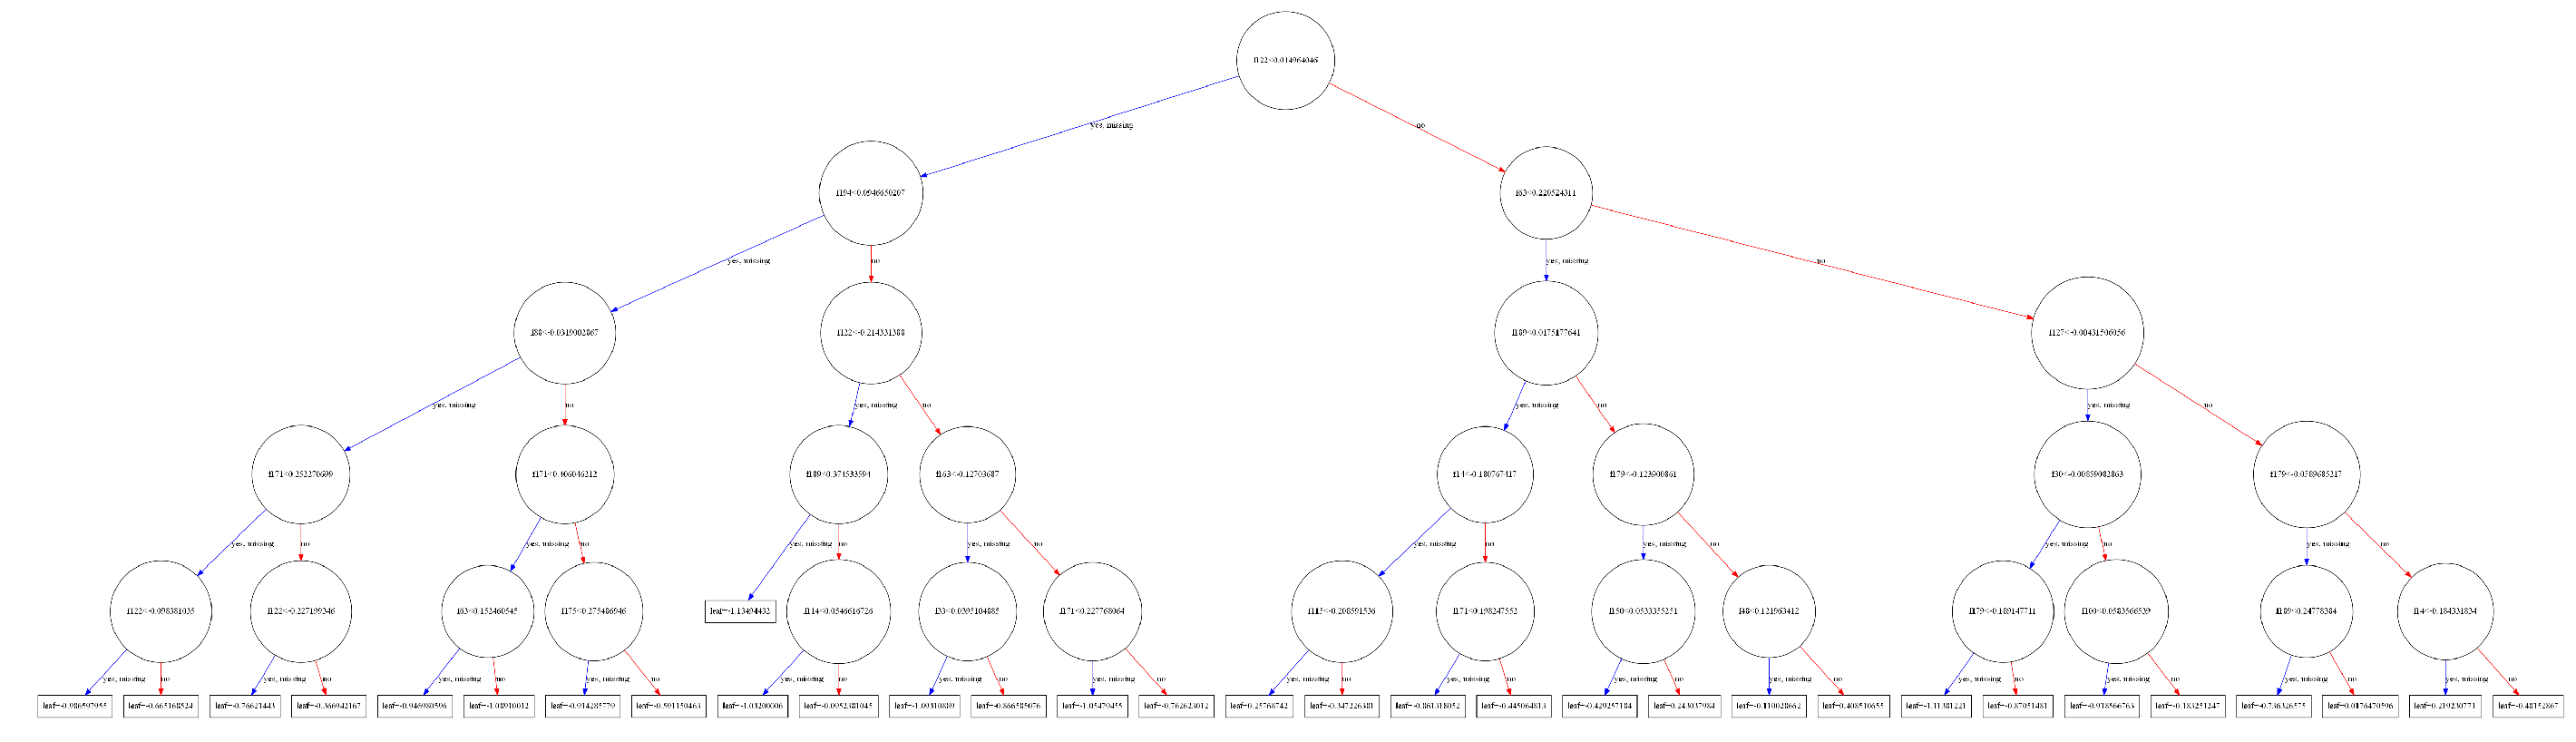

<Figure size 3600x3600 with 0 Axes>

In [64]:
from xgboost import plot_tree
import xgboost as xgb
xgb.plot_tree(xgb_optimal,num_trees=0)
plt.figure(figsize=(50,50))
plt.show()

In [66]:
#Confusion matrix
C = confusion_matrix(y_test, pred_avg_w2v)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
labels = [0,1]

-------------------- Confusion matrix --------------------


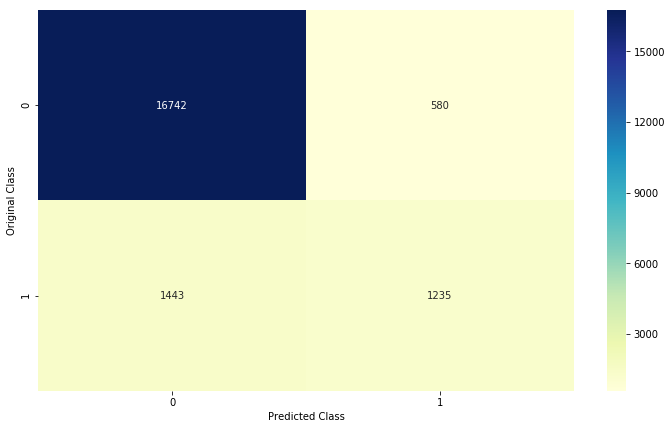

-------------------- Precision matrix (Columm Sum=1) --------------------


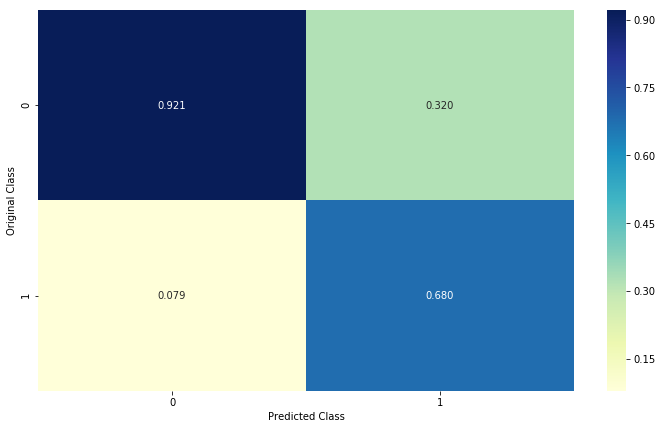

-------------------- Recall matrix (Row sum=1) --------------------


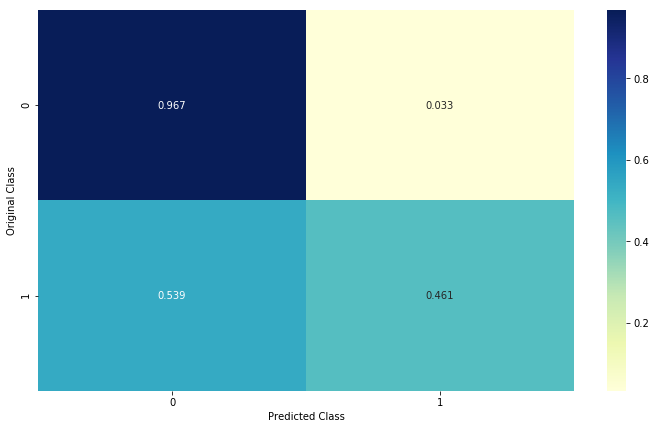

In [67]:
 print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
    
    # representing B in heatmap format
print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### Tfidf-W2V

Importing Pre-featurized pickle file

In [34]:
#Train
with open('train.pickle', 'rb') as f:
   tfidf_w2v_sent_vectors_train = pickle.load(f)

In [35]:
#Test
with open('test.pickle', 'rb') as f:
    tfidf_w2v_sent_vectors_test = pickle.load(f)

In [41]:
tfidf_w2v_sent_vectors_train=np.asarray(tfidf_w2v_sent_vectors_train)
tfidf_w2v_sent_vectors_test=np.asarray(tfidf_w2v_sent_vectors_test)

In [42]:
grid.fit(tfidf_w2v_sent_vectors_train, y_train)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.44570093765091245
{'n_estimators': 900, 'max_depth': 6, 'learning_rate': 1.0}


Text(0,0.5,'Cross-Validated Error')

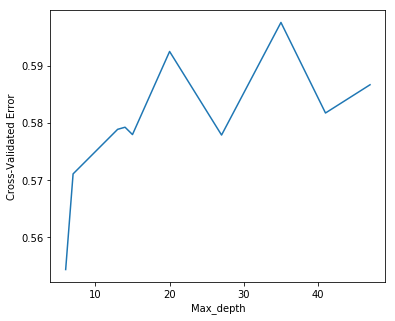

In [44]:
#Plotting Max_depth v/s CV_error
a=pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
a['max_depth'] = [d.get('max_depth') for d in a['params']]
b=a.sort_values(['max_depth'])
CV_Error=1-b['mean_test_score']
max_depth =b['max_depth']

plt.figure(figsize=(6,5))
plt.plot(max_depth,CV_Error)
plt.xlabel('Max_depth')
plt.ylabel('Cross-Validated Error')

In [49]:
from sklearn.metrics import f1_score
#{'n_estimators': 900, 'max_depth': 6, 'learning_rate': 1.0}
xgb_optimal=XGBClassifier(n_estimators=900,max_depth=6,learning_rate=1.0,gamma=20 ,n_jobs=-1)

# fitting the model
xgb_optimal.fit(tfidf_w2v_sent_vectors_train, y_train)

# predict the response
pred_tfidf_w2v = xgb_optimal.predict(tfidf_w2v_sent_vectors_test)

# evaluate f1_score
f1_score = f1_score(y_test, pred_tfidf_w2v)

# Train & Test Error
print("The overall f1_score for the Train Data is : ", metrics.f1_score(y_train,xgb_optimal.predict(tfidf_w2v_sent_vectors_train)))
print("The overall f1_score for the Test Data is : ", metrics.f1_score(y_test,pred_tfidf_w2v))

The overall f1_score for the Train Data is :  0.565834065520271
The overall f1_score for the Test Data is :  0.44323835368611486


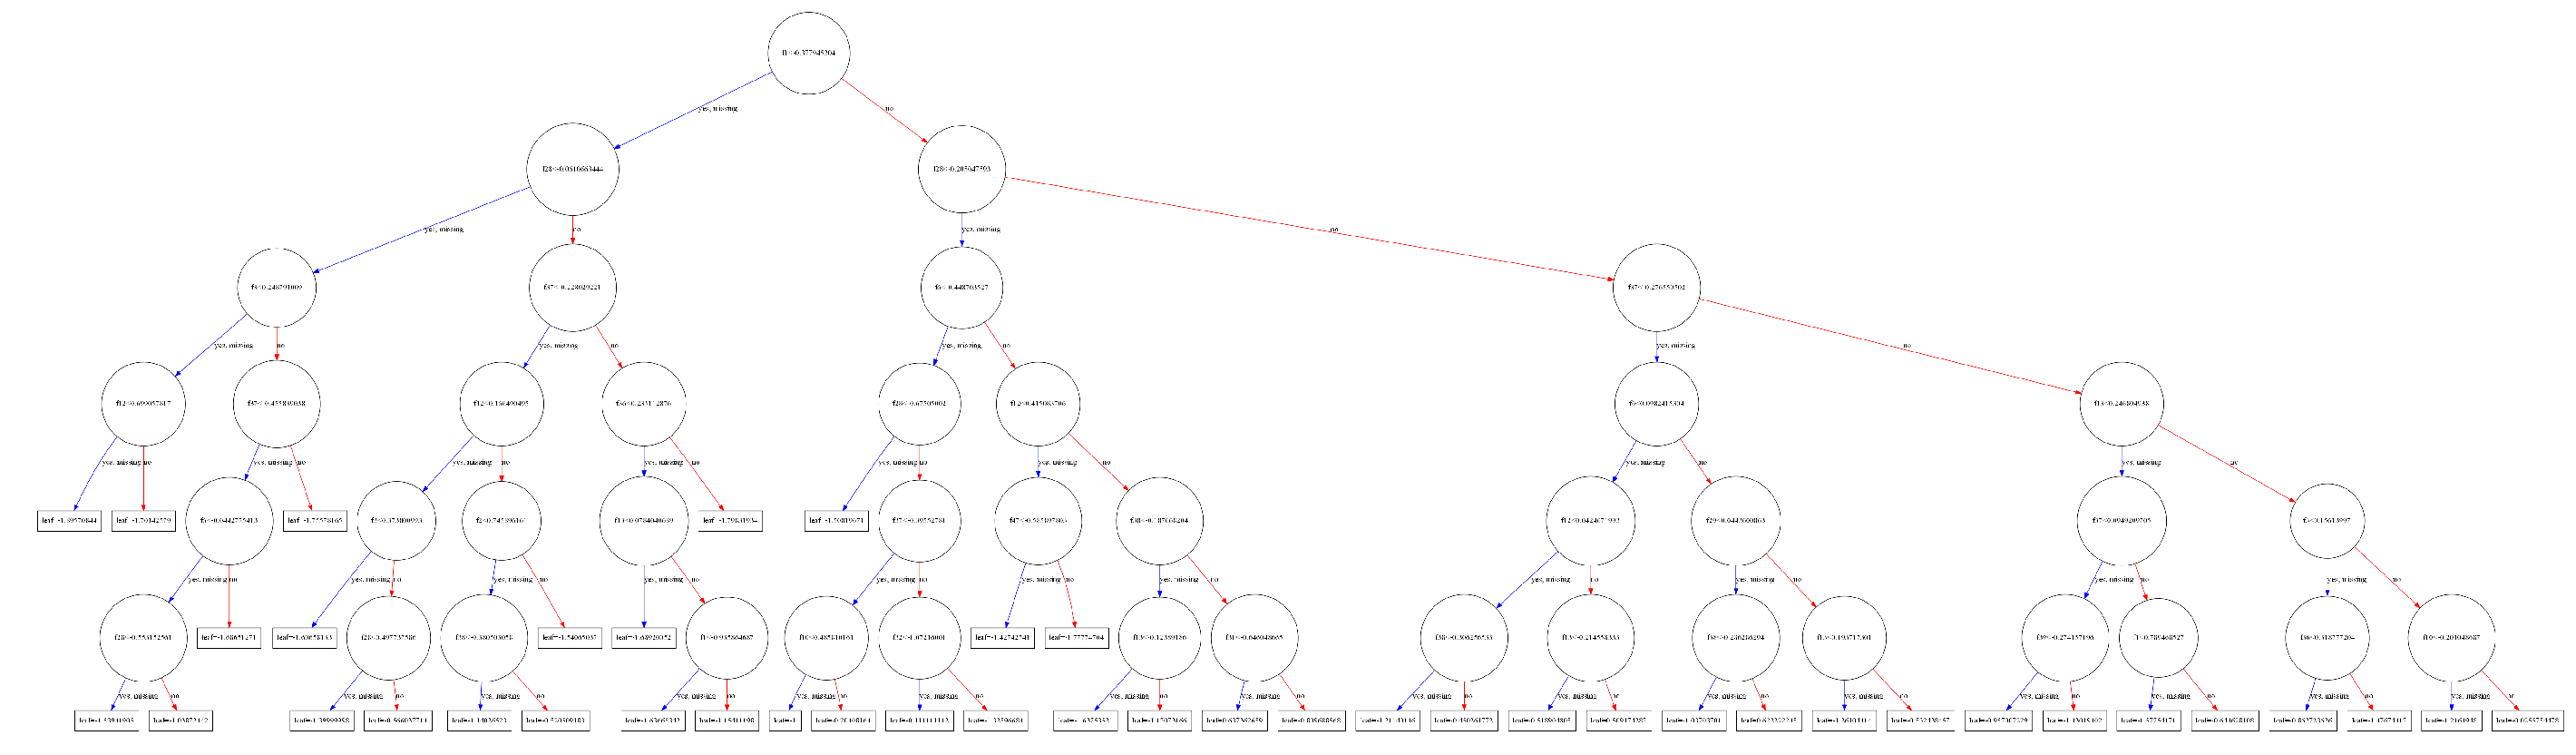

<Figure size 3600x3600 with 0 Axes>

In [51]:
from xgboost import plot_tree
import xgboost as xgb
xgb.plot_tree(xgb_optimal,num_trees=0)
plt.figure(figsize=(50,50))
plt.show()

In [52]:
#Confusion matrix
C = confusion_matrix(y_test, pred_tfidf_w2v)
A =(((C.T)/(C.sum(axis=1))).T)
B =(C/C.sum(axis=0))
labels = [0,1]

-------------------- Confusion matrix --------------------


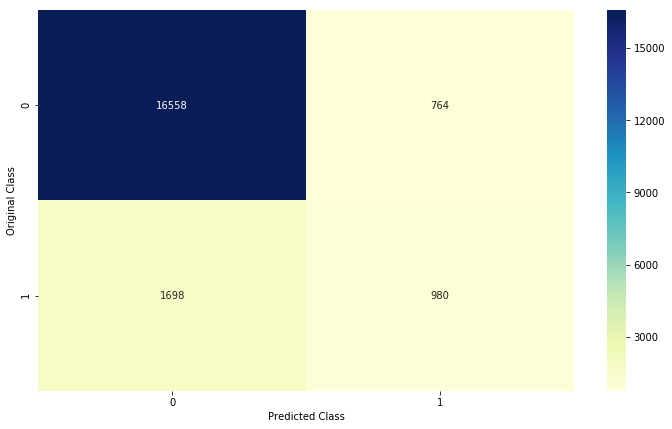

-------------------- Precision matrix (Columm Sum=1) --------------------


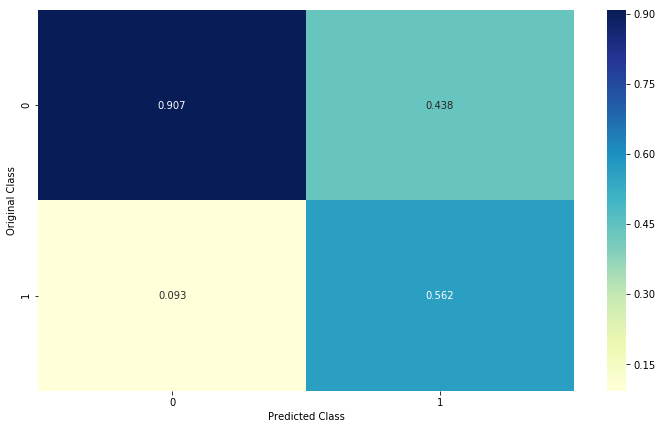

-------------------- Recall matrix (Row sum=1) --------------------


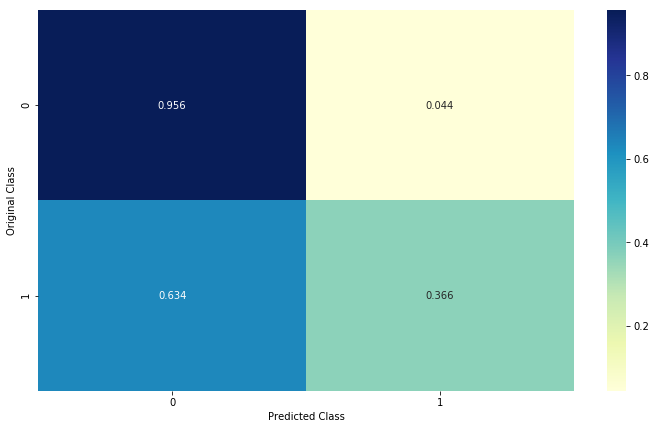

In [53]:
 print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="g", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
 plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
    
    # representing B in heatmap format
print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
plt.figure(figsize=(12,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

***********************************************************************************************************************************************